In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


In [2]:
import pandas as pd
from src.modules.data_preprocessing import normalization, move_target_to_end
from dython.nominal import correlation_ratio
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns


ModuleNotFoundError: No module named 'dython'

# Classification Data

In [53]:
def convert_gaussian(data, target_col):
    for col in data.columns:
        if col != target_col:
            pt = PowerTransformer()
            data[col] = pt.fit_transform(data[col].values.reshape(-1, 1)).flatten()
    return data

In [54]:
def run_regression(data, target_col):

    X_train, X_test, y_train, y_test = train_test_split(data.drop(target_col, axis=1), data[target_col], test_size=0.2, random_state=42)

    clf = MLPRegressor(hidden_layer_sizes = [64, 64], random_state=42, max_iter=1000).fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("RMSE: {}".format(rmse))
    print("R2: {}".format(r2))

In [267]:
def run_classification(data, target_col):

    X_train, X_test, y_train, y_test = train_test_split(data.drop(target_col, axis=1), data[target_col], test_size=0.2, random_state=42)

    clf = MLPClassifier(hidden_layer_sizes = [64, 64], random_state=42, max_iter=1000).fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accu = clf.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Accuracy: {}".format(accu))
    print("F1: {}".format(f1))

    clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accu = clf.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: {}".format(accu))
    print("F1: {}".format(f1))

## Iris

In [17]:
normalize = True
threshold = 0.3
data = pd.read_csv("./data/iris/iris.csv", header=None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
data['5'] = data['5'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
target_col = '5'

if normalize:
	data = normalization(data, target_col)

# move target to the end of the dataframe
data = move_target_to_end(data, target_col)

# correlation
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
data_config = {
	'target': 'diagnosis',
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != 'diagnosis'],
	'num_cols': data.shape[1] - 1,
	'task_type': 'classification',
	'clf_type': 'multi-class'
}
correlation_ret

['3', '4', '1', '2']
(150, 5)
3
Average correlation: 0.8366399020186166 0.9702159417163926
0    0.333333
1    0.333333
2    0.333333
Name: 5, dtype: float64


5    1.000000
3    0.970216
4    0.963761
1    0.786578
2    0.626004
dtype: float64

## Breast Cancer

In [10]:
normalize = True
threshold = 0.3
data = pd.read_csv("./data/breast/data.csv", header=0)
data = data.drop(["id"], axis=1)
data = data.dropna()
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

target_col = 'diagnosis'

if normalize:
	data = normalization(data, target_col)

# drop co-linear features
drop_list = ['perimeter_mean', 'radius_mean', 'compactness_mean', 'concave points_mean', 'radius_se',
			 'perimeter_se', 'radius_worst', 'perimeter_worst', 'compactness_worst', 'concave points_worst',
			 'compactness_se', 'concave points_se', 'texture_worst', 'area_worst']
data = data.drop(drop_list, axis=1)  # do not modify x, we will use it later

# move target to the end of the dataframe
data = move_target_to_end(data, target_col)

# correlation
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
# data_config = {
# 	'target': 'diagnosis',
# 	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
# 	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != 'diagnosis'],
# 	'num_cols': data.shape[1] - 1,
# 	'task_type': 'classification',
# 	'clf_type': 'binary-class'
# }
correlation_ret

['area_mean', 'concavity_mean', 'concavity_worst', 'area_se', 'smoothness_worst', 'symmetry_worst', 'texture_mean', 'smoothness_mean', 'symmetry_mean', 'fractal_dimension_worst']
(569, 17)
2
Average correlation: 0.33159035999547587 0.70898383658539
0    0.627417
1    0.372583
Name: diagnosis, dtype: float64


diagnosis                  1.000000
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
area_se                    0.548236
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
concavity_se               0.253730
fractal_dimension_se       0.077972
smoothness_se              0.067016
fractal_dimension_mean     0.012838
texture_se                 0.008303
symmetry_se                0.006522
dtype: float64

## Wine Red

In [20]:
threshold = 0.15
data = pd.read_csv("./data/wine/winequality-red.csv", delimiter=';')

# data = data.drop(["id", "Unnamed: 32"], axis=1)
data = data.dropna()

print(data['quality'].value_counts())
#data['target'] = data.apply(lambda row: 0 if row['quality'] <= 5 else 1, axis=1)
#data = data.drop('quality', axis=1)

target_col = 'quality'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)

# print("Wine Red data loaded. Train size {}, Test size {}".format(train.shape, test.shape))
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)

# data_config = {
# 	'target': target_col,
# 	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
# 	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
# 	"num_cols": data.shape[1] - 1,
# 	'task_type': 'classification',
# 	'clf_type': 'binary-class'
# }

# if verbose:
# 	print("Data shape {} Test shape {}".format(data.shape))
# 	print(data_config)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64
['alcohol', 'volatile acidity', 'total sulfur dioxide', 'sulphates', 'citric acid', 'density']
(1599, 12)
6
Average correlation: 0.22335763929061636 0.5163981913679647
5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64


quality                 1.000000
alcohol                 0.516398
volatile acidity        0.400631
total sulfur dioxide    0.272119
sulphates               0.255621
citric acid             0.241260
density                 0.200875
fixed acidity           0.139067
chlorides               0.136353
free sulfur dioxide     0.121255
pH                      0.115950
residual sugar          0.057405
dtype: float64

## Wine White

In [22]:
threshold = 0.15
data = pd.read_csv("./data/wine/winequality-white.csv", delimiter=';')
data = data.dropna()
print(data['quality'].value_counts())
#data['target'] = data.apply(lambda row: 0 if row['quality'] <= 5 else 1, axis=1)
#data = data.drop(['quality'], axis=1)

target_col = 'quality'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64
['alcohol', 'density', 'volatile acidity', 'total sulfur dioxide', 'chlorides', 'residual sugar', 'free sulfur dioxide']
(4898, 12)
7
Average correlation: 0.20032979867866105 0.4688951098954679
6    0.448755
5    0.297468
7    0.179665
8    0.035729
4    0.033279
3    0.004083
9    0.001021
Name: quality, dtype: float64


quality                 1.000000
alcohol                 0.468895
density                 0.339018
volatile acidity        0.265695
total sulfur dioxide    0.229209
chlorides               0.222536
residual sugar          0.159467
free sulfur dioxide     0.153702
fixed acidity           0.124789
pH                      0.110645
sulphates               0.066696
citric acid             0.062975
dtype: float64

## Wine all three

In [6]:
threshold = 0.1
normalize = True
# merge data
data_white = pd.read_csv("./data/wine/winequality-white.csv", delimiter=';')
data_white['type'] = 0
data_red = pd.read_csv("./data/wine/winequality-red.csv", delimiter=';')
data_red['type'] = 1
data = pd.concat([data_white, data_red], axis=0)
data = data.dropna()

# label
data['quality'] = data.apply(lambda row: 0 if row['quality'] <= 5 else 1 if row['quality'] <=7 else 2, axis=1)
print(data['quality'].value_counts())
target_col = 'quality'
data = move_target_to_end(data, target_col)

# normalize
if normalize:
    data = normalization(data, target_col, categorical_cols=['type'])

# correlation
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret
data

1    3915
0    2384
2     198
Name: quality, dtype: int64
['alcohol', 'density', 'volatile acidity', 'chlorides', 'type']
(6497, 13)
3
Average correlation: 0.13679298297333367 0.4143662905490882
1    0.602586
0    0.366939
2    0.030476
Name: quality, dtype: float64


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942,0,1
1,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391,0,1
2,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348,0,1
3,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,0,1
4,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,0.198347,0.346667,0.048193,0.021472,0.134551,0.107639,0.087558,0.150183,0.565891,0.202247,0.362319,1,0
1595,0.173554,0.313333,0.060241,0.024540,0.088040,0.131944,0.103687,0.154425,0.620155,0.303371,0.463768,1,1
1596,0.206612,0.286667,0.078313,0.026074,0.111296,0.097222,0.078341,0.166377,0.542636,0.297753,0.434783,1,1
1597,0.173554,0.376667,0.072289,0.021472,0.109635,0.107639,0.087558,0.161172,0.658915,0.275281,0.318841,1,0


## Spambase

In [ ]:
threshold = 0.1
data = pd.read_csv("./data/spambase/spambase.csv", header=None)

# data = data.drop(["id", "Unnamed: 32"], axis=1)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '58'

# Normalization
if normalize:
	data = normalization(data, target_col)

# move target to the end of the dataframe
data = move_target_to_end(data, target_col)

# split train and test
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## Block data

In [ ]:
threshold = 0.2
data = pd.read_csv("./data/block/page-blocks.csv", delimiter='\s+', header=None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '11'
data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
data_config = {
		'target': target_col,
		'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
		'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
		"num_cols": data.shape[1] - 1,
		'task_type': 'classification',
	}
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## Ecoli

In [4]:
normalize = True
threshold = 0.2
data = pd.read_csv("./data/ecoli/ecoli.csv", delimiter='\s+', header=None)
data = data.dropna()
data  = data.drop([0], axis=1)
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '8'
if normalize:
	data = normalization(data, target_col)
data[target_col] = data[target_col].map(
		{'cp': 0, 'im': 1, 'pp': 2, 'imU': 3, 'om': 4, 'omL': 5, 'imL': 6, 'imS': 7}
	)
data = move_target_to_end(data, target_col)
data[target_col] = pd.factorize(data[target_col])[0]
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret
# if verbose:
# 	logger.debug("Important features {}".format(important_features))
# 	logger.debug("Data shape {}".format(data.shape, data.shape))
# 	logger.debug(data_config)

(336, 8)
8
Average correlation: 0.7634879968279279 0.8914591490774081
8
0    0.425595
1    0.229167
7    0.154762
4    0.104167
5    0.059524
6    0.014881
2    0.005952
3    0.005952
Name: proportion, dtype: float64


8    1.000000
6    0.891459
3    0.836800
7    0.816406
2    0.754526
1    0.726390
4    0.706051
5    0.612785
dtype: float64

In [12]:
data['4'].value_counts(normalize=True)[0]

0.9970238095238095

## Glass Data

In [ ]:
normalize = True
threshold = 0.15
data = pd.read_csv("./data/glass/glass.csv", delimiter=',', header=None)
data = data.dropna()
data  = data.drop([0], axis=1)
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '10'
if normalize:
 	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
data = data[data[target_col] != 6]
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## OptDigits

In [ ]:
normalize = True
threshold = 0.5
data_test = pd.read_csv("./data/optdigits/optdigits_test.csv", delimiter=',', header=None)
data_train = pd.read_csv("./data/optdigits/optdigits_train.csv", delimiter=',', header=None)
data = pd.concat([data_test, data_train]).reset_index(drop=True)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '65'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
correlation_ret
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## Segmentation

In [ ]:
normalize = True
threshold = 0.5
data_test = pd.read_csv("./data/segment/segmentation_test.csv", delimiter=',')
data_train = pd.read_csv("./data/segment/segmentation.csv", delimiter=',')
data = pd.concat([data_test, data_train]).reset_index(drop=True)
data = data.dropna()
target_col = 'TARGET'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
data[target_col].value_counts()
data[target_col] = data[target_col].map({
	'BRICKFACE': 0,
	'SKY': 1,
	'FOLIAGE': 2,
	'CEMENT': 3,
	'WINDOW': 4,
	'PATH': 5,
	'GRASS': 6,
})
data = data.drop(["REGION-PIXEL-COUNT"], axis = 1)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## Sonar

In [ ]:
normalize = True
threshold = 0.15
data = pd.read_csv("./data/sonar/sonar.csv", delimiter=',', header=None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '61'
if normalize:
 	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
data[target_col] = data[target_col].map({
	'R': 0,
	'M': 1,
})
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## Sensor

In [122]:
normalize = True
threshold = 0.2
pca = True
data = pd.read_csv("./data/sensor/Sensorless_drive_diagnosis.csv", delimiter='\s+', header=None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '49'
print(data.shape)
if normalize:
	data = normalization(data, target_col)

if pca:
	pca = PCA(n_components=10)
	pca.fit(data.drop(target_col, axis=1))
	data = pd.concat([pd.DataFrame(pca.transform(data.drop(target_col, axis=1))), data[target_col]], axis=1)

data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
#data = data[important_features + [target_col]]
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

(58509, 49)
[1, 2, 3]
(58509, 11)
11
Average correlation: 0.27216658940385624 0.9784887849947083
49
1     0.090909
2     0.090909
3     0.090909
4     0.090909
5     0.090909
6     0.090909
7     0.090909
8     0.090909
9     0.090909
10    0.090909
11    0.090909
Name: proportion, dtype: float64


49    1.000000
1     0.978489
2     0.767892
3     0.325555
4     0.197333
0     0.151313
9     0.148325
7     0.063658
8     0.039029
5     0.025545
6     0.024528
dtype: float64

In [123]:
run_classification(data, target_col=target_col)

d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Accuracy: 0.9938472056058794
F1: 0.9938468024779495


## Waveform

In [ ]:
normalize = True
threshold = 0.15
data = pd.read_csv("./data/waveform/waveform-5000.csv", delimiter=',', header=None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '41'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
data[target_col] = data[target_col].map({'N': 0,'P': 1})
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret


## Yeast

In [11]:
normalize = True
threshold = 0.4
data = pd.read_csv("./data/yeast/yeast.csv", delimiter='\s+', header=None)
data = data.drop([0], axis = 1)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '9'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)
print(data[target_col].value_counts())
data[target_col] = data[target_col].map({
	'CYT': 0,
	'NUC': 1,
	'MIT': 2,
	'END': 3,
	'ME3': 4,
	'ME2': 5,
	'ME1': 6,
	'EXC': 7,
	'VAC': 8,
	'POX': 9,
	'ERL': 10,
})
data = data[data[target_col] != 10]
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: 9, dtype: int64
['3', '6', '1', '2', '4']
(1479, 9)
9
Average correlation: 0.44110086913680074 0.6782641275813955
0    0.313049
1    0.290061
2    0.164976
4    0.110210
5    0.034483
6    0.029750
7    0.023665
8    0.020284
9    0.013523
Name: 9, dtype: float64


9    1.000000
3    0.678264
6    0.644011
1    0.609456
2    0.545681
4    0.489175
8    0.343947
7    0.163831
5    0.054441
dtype: float64

## Letter

In [31]:
normalize = True
threshold = 0.3
data = pd.read_csv("./data/letter/letter-recognition.csv", delimiter=',', header=None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '1'
data = move_target_to_end(data, target_col)
# convert columns to gaussian
data = convert_gaussian(data, target_col)

if normalize:
	data = normalization(data, target_col)

#data[target_col].value_counts()
data[target_col] = data[target_col].map(lambda x: ord(x) - ord('A'))
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)

important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

['12', '8', '14', '13', '15', '10', '16', '9', '7', '11', '17', '4', '6', '2']
(20000, 17)
26
Average correlation: 0.538381865210026 0.7785937224191333
1
20    0.04065
3     0.04025
15    0.04015
19    0.03980
12    0.03960
0     0.03945
23    0.03935
24    0.03930
13    0.03915
16    0.03915
5     0.03875
6     0.03865
4     0.03840
1     0.03830
21    0.03820
11    0.03805
17    0.03790
8     0.03775
14    0.03765
22    0.03760
18    0.03740
9     0.03735
10    0.03695
2     0.03680
7     0.03670
25    0.03670
Name: proportion, dtype: float64


1     1.000000
12    0.778594
8     0.771149
14    0.746649
13    0.731932
15    0.731113
10    0.694809
16    0.678927
9     0.614407
7     0.552050
11    0.551592
17    0.516553
4     0.380062
6     0.363800
2     0.319234
5     0.118186
3     0.065056
dtype: float64

<Axes: >

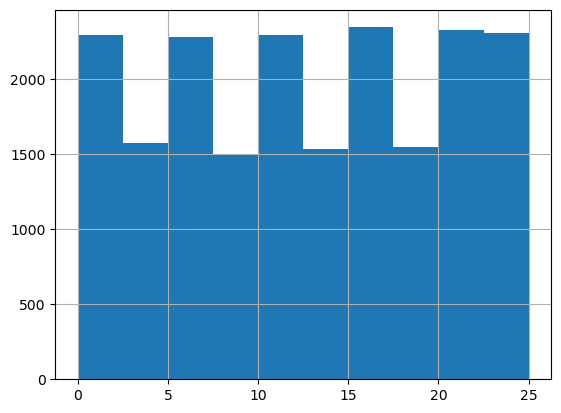

In [29]:
col = data.columns[16]
data[col].hist()

In [32]:
run_classification(data, target_col)

Accuracy: 0.92125
F1: 0.9210670105135317


C:\Users\sitao\miniconda3\envs\fed_imp\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


## Raisin

In [ ]:
normalize = True
threshold = 0.2
data = pd.read_csv("./data/raisin/Raisin_Dataset.csv", delimiter=',')
data = data.dropna()
target_col = 'Class'
data = move_target_to_end(data, target_col)
if normalize:
 	data = normalization(data, target_col)
#data[target_col].value_counts()
data[target_col] = data[target_col].map({"Kecimen": 0, "Besni": 1})
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## Dermatology

In [ ]:
normalize = True
threshold = 0.5
data = pd.read_csv("./data/dermatology/dermatology.csv", delimiter=',', na_values='?', header = None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '35'
data = move_target_to_end(data, target_col)
if normalize:
 	data = normalization(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	"num_cols": data.shape[1] - 1,
	'task_type': 'classification',
	'clf_type': 'multi-class'
}
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

## Pima Indianas Diabetes

In [13]:
normalize = True
threshold = 0.1
data = pd.read_csv("./data/pima_indianas_diabetes/diabetes.csv", delimiter=',', header=0)
data['Outcome'].value_counts()
target_col = 'Outcome'

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
print(correlation_ret)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
dtype: float64
['Glucose', 'BMI', 'Age', 'Pregnancies', 'DiabetesPedigreeFunction', 'Insulin']
(768, 9)
2
Average correlation: 0.20796785112727043 0.4665813983068738
0    0.651042
1    0.348958
Name: Outcome, dtype: float64


## Telugu Vowel

In [7]:
normalize = True
threshold = 0.1

data = pd.read_csv("./data/telugu_vowel/telugu.csv", delimiter=',', header=0)
target_col = 'class'

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)

important_features = data.columns.tolist()
important_features.remove(target_col)
print(data['class'].value_counts())

1    200
2    200
3    200
4    200
5    200
6    200
Name: class, dtype: int64


## Telugu Tabular

In [4]:
normalize = True
threshold = 0.1

data = pd.read_csv("./data/telugu_tabular/telugu.csv", delimiter='\s+', header=None)
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '1'

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)
data[target_col] = pd.factorize(data[target_col])[0]

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)

important_features = data.columns.tolist()
important_features.remove(target_col)
print(data[target_col].value_counts())

1
4    207
5    180
2    172
3    151
1     89
0     72
Name: count, dtype: int64


## Wine Data

In [22]:
normalize = True
threshold = 0.1

data = pd.read_csv("./data/wine2/wine.csv", delimiter=',', header=None)
data = data.dropna()
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = '1'

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
# print(data[target_col].value_counts())

['8', '14', '13', '2', '11', '12', '7', '3', '5', '10', '9', '4', '6']


## Parkinsons

## Wifi Localization

In [12]:
normalize = True
threshold = 0.5

data = pd.read_csv("./data/wifi_localization/wifi_localization.csv", delimiter='\s+', header=None)
data = data.dropna()
# data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
target_col = 7

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)
data[target_col] = pd.factorize(data[target_col])[0]

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data[target_col].value_counts())
print(data.shape)
correlation_ret

[3, 0, 4, 5, 6, 2]
7
0    500
1    500
2    500
3    500
Name: count, dtype: int64
(2000, 8)


7    1.000000
3    0.894730
0    0.893372
4    0.880661
5    0.803960
6    0.771457
2    0.698395
1    0.170905
dtype: float64

## Adult

In [21]:
from sklearn.preprocessing import OneHotEncoder

In [28]:
normalize = True
threshold = 0.1
retain_threshold = 0.05

columns = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
	           "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
	           "Hours per week", "Country", "Target"]
types = {
    0: int, 1: str, 2: int, 3: str, 4: int, 5: str, 6: str, 7: str, 8: str, 9: str, 10: int,
    11: int, 12: int, 13: str, 14: str
}

data_train = pd.read_csv(
    "./data/adult/adult_train.csv", names=columns, na_values=['?'], sep=r'\s*,\s*', engine='python',
    dtype=types
)
data_test = pd.read_csv(
    "./data/adult/adult_test.csv", names=columns, na_values=['?'], sep=r'\s*,\s*', engine='python',
    dtype=types
)
data = pd.concat([data_train, data_test], axis=0)
data = data.dropna()
col_drop = ["Country", "Education", "fnlwgt"]
data = data.drop(col_drop, axis=1)
# target
target_col = 'Target'
data[target_col] = data[target_col].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})

# convert categorical to numerical
for col in ["Sex", "Martial Status", "Relationship", "Race",  "Workclass", "Occupation"]:
    values = data[col].value_counts().index.tolist()
    corr_y = []
    for value in values:
        corr_y_data = data[data[col] == value][target_col].value_counts(normalize=True)
        corr = corr_y_data[0]/corr_y_data[1]
        corr_y.append(corr)

    sorted_values = sorted(values, key = lambda x: corr_y[values.index(x)])
    mapping = {value: idx for idx, value in enumerate(sorted_values)}
    print(mapping)
    data[col] = data[col].map(mapping)

# one-hot encoding
# categorical_features = [
#     "Workclass", "Education", "Martial Status", "Occupation", "Relationship", "Race", "Sex", "Country"
# ]
# one_hot_encoder = OneHotEncoder(
#     categories='auto', handle_unknown='ignore', drop='first', max_categories=5
# )
# one_hot_encoder.fit(data[categorical_features])
# one_hot_encoded = one_hot_encoder.transform(data[categorical_features]).toarray()
# one_hot_encoded = pd.DataFrame(one_hot_encoded)
# data = data.drop(categorical_features, axis=1).reset_index(drop=True)
# num_cols = data.shape[1] - 1
# data = pd.concat([data, one_hot_encoded], axis=1)

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)
data[target_col] = pd.factorize(data[target_col])[0]

# # sample balance
# data_y0 = data[data[target_col] == 0]
# data_y1 = data[data[target_col] == 1]
# data_y0 = data_y0.sample(n=data_y1.shape[0], random_state=0)
# data = pd.concat([data_y0, data_y1], axis=0).reset_index(drop=True)


correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
# retained_features = correlation_ret[correlation_ret >= retain_threshold].index.tolist()
# new_cols = []
# new_num_cols = 0
# for idx, feature in enumerate(data.columns.tolist()):
#     if feature in retained_features:
#         new_cols.append(feature)
#         if idx < num_cols:
#             new_num_cols += 1

# data = data[new_cols]

important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular'
}
correlation_ret

{'Male': 0, 'Female': 1}
{'Married-civ-spouse': 0, 'Married-AF-spouse': 1, 'Divorced': 2, 'Married-spouse-absent': 3, 'Widowed': 4, 'Separated': 5, 'Never-married': 6}
{'Wife': 0, 'Husband': 1, 'Not-in-family': 2, 'Unmarried': 3, 'Other-relative': 4, 'Own-child': 5}
{'Asian-Pac-Islander': 0, 'White': 1, 'Other': 2, 'Black': 3, 'Amer-Indian-Eskimo': 4}
{'Self-emp-inc': 0, 'Federal-gov': 1, 'Local-gov': 2, 'Self-emp-not-inc': 3, 'State-gov': 4, 'Private': 5, 'Without-pay': 6}
{'Exec-managerial': 0, 'Prof-specialty': 1, 'Protective-serv': 2, 'Tech-support': 3, 'Armed-Forces': 4, 'Sales': 5, 'Craft-repair': 6, 'Transport-moving': 7, 'Adm-clerical': 8, 'Machine-op-inspct': 9, 'Farming-fishing': 10, 'Handlers-cleaners': 11, 'Other-service': 12, 'Priv-house-serv': 13}


Target            1.000000
Martial Status    0.413213
Relationship      0.383811
Occupation        0.341454
Education-Num     0.332800
Age               0.237040
Hours per week    0.227199
Capital Gain      0.221034
Sex               0.215760
Workclass         0.150828
Capital Loss      0.148687
Race              0.096798
dtype: float64

## Default Credit

In [45]:
normalize = True
threshold = 0.1
retain_threshold = 0.1


data = pd.read_csv("./data/default_credit/default_creidt.csv")
data = data.dropna()
data = data.drop('ID', axis=1)

# target
target_col = 'default payment next month'

# convert categorical to numerical
for col in ["SEX", "MARRIAGE", "EDUCATION"]:
    values = data[col].value_counts().index.tolist()
    corr_y = []
    for value in values:
        corr_y_data = data[data[col] == value][target_col].value_counts(normalize=True)
        if corr_y_data.shape[0] == 1:
            if corr_y_data.index[0] == 0:
                corr = 0
            else:
                corr = 1e5
        else:
            corr = corr_y_data[0]/corr_y_data[1]
        
        corr_y.append(corr)

    sorted_values = sorted(values, key = lambda x: corr_y[values.index(x)])
    mapping = {value: idx for idx, value in enumerate(sorted_values)}
    print(mapping)
    data[col] = data[col].map(mapping)

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)
data[target_col] = pd.factorize(data[target_col])[0]

# # sample balance
# data_y0 = data[data[target_col] == 0]
# data_y1 = data[data[target_col] == 1]
# data_y1 = data_y1.sample(n=data_y0.shape[0], random_state=0)
# data = pd.concat([data_y0, data_y1], axis=0).reset_index(drop=True)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

retained_features = correlation_ret[correlation_ret >= retain_threshold].index.tolist()
new_cols = []
for idx, feature in enumerate(data.columns.tolist()):
    if feature in retained_features:
        new_cols.append(feature)

data = data[new_cols]

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular'
}

correlation_ret

{1: 0, 2: 1}
{3: 0, 1: 1, 2: 2, 0: 3}
{0: 0, 3: 1, 2: 2, 1: 3, 6: 4, 5: 5, 4: 6}


default payment next month    1.000000
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
LIMIT_BAL                     0.153520
PAY_AMT1                      0.072929
EDUCATION                     0.068142
PAY_AMT2                      0.058579
PAY_AMT4                      0.056827
PAY_AMT3                      0.056250
PAY_AMT5                      0.055124
PAY_AMT6                      0.053183
SEX                           0.039961
MARRIAGE                      0.033213
BILL_AMT1                     0.019644
BILL_AMT2                     0.014193
BILL_AMT3                     0.014076
AGE                           0.013890
BILL_AMT4                     0.010156
BILL_AMT5                     0.006760
BILL_AMT6                     0.005372
dtype: float64

## Firewall

In [106]:
normalize = True
threshold = 0.1
retain_threshold = 0.1


data = pd.read_csv("./data/firewall/log2.csv")
data = data[data['Action'] != 'reset-both']
target_col = 'Action'
data[target_col] = pd.factorize(data[target_col])[0]
data = data.dropna()
source_freq = data['Source Port'].value_counts(normalize=True)
source_freq.name = 'source_freq'
destination_freq = data['Destination Port'].value_counts(normalize=True)
destination_freq.name = 'destination_freq'
nat_source_freq = data['NAT Source Port'].value_counts(normalize=True)
nat_source_freq.name = 'nat_source_freq'
nat_destination_freq = data['NAT Destination Port'].value_counts(normalize=True)
nat_destination_freq.name = 'nat_destination_freq'

data = data.merge(source_freq, how = 'left', left_on='Source Port', right_index=True)
data = data.merge(destination_freq, how = 'left', left_on='Destination Port', right_index=True)
data = data.merge(nat_source_freq, how = 'left', left_on='NAT Source Port', right_index=True)
data = data.merge(nat_destination_freq, how = 'left', left_on='NAT Destination Port', right_index=True)
data['sd_pair'] = data[['Source Port', 'Destination Port']].apply(lambda x: tuple(x), axis=1)
data['nat_sd_pair'] = data[['NAT Source Port', 'NAT Destination Port']].apply(lambda x: tuple(x), axis=1)
sd_pair_freq = data['sd_pair'].value_counts(normalize=True)
sd_pair_freq.name = 'sd_pair_freq'
nat_sd_pair_freq = data['nat_sd_pair'].value_counts(normalize=True)
nat_sd_pair_freq.name = 'nat_sd_pair_freq'
data = data.merge(sd_pair_freq, how = 'left', left_on='sd_pair', right_index=True)
data = data.merge(nat_sd_pair_freq, how = 'left', left_on='nat_sd_pair', right_index=True)

data = data.drop([
    'sd_pair', 'nat_sd_pair', 'Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port'
    ], axis=1)

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)

# # # sample balance
# # data_y0 = data[data[target_col] == 0]
# # data_y1 = data[data[target_col] == 1]
# # data_y1 = data_y1.sample(n=data_y0.shape[0], random_state=0)
# # data = pd.concat([data_y0, data_y1], axis=0).reset_index(drop=True)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}
print(data.shape)
correlation_ret

(65478, 14)


Action                  1.000000
nat_sd_pair_freq        0.982195
nat_source_freq         0.982195
nat_destination_freq    0.886994
destination_freq        0.714055
sd_pair_freq            0.200021
Elapsed Time (sec)      0.187267
source_freq             0.180081
Bytes Received          0.026105
pkts_received           0.023785
Packets                 0.017074
Bytes                   0.014861
pkts_sent               0.010798
Bytes Sent              0.005014
dtype: float64

In [105]:
run_classification(data, target_col=target_col)

Accuracy: 0.9980146609651802
F1: 0.99801223267393


## Dry Bean

In [103]:
normalize = True
threshold = 0.1
retain_threshold = 0.1

data = pd.read_excel("./data/dry_bean/Dry_Bean_Dataset.xlsx")
target_col = 'Class'
# data = data[data['Action'] != 'reset-both']
# target_col = 'Action'
data[target_col] = pd.factorize(data[target_col])[0]
data = data.dropna()
data = data.drop(['Extent', 'Solidity', 'ShapeFactor4', 'roundness'], axis=1)

# convert columns to gaussian
data = convert_gaussian(data, target_col)

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}
print(data.shape)
correlation_ret

(13611, 13)


Class              1.000000
MajorAxisLength    0.931274
Perimeter          0.930830
ShapeFactor2       0.928938
ConvexArea         0.922399
EquivDiameter      0.921556
Area               0.921539
Compactness        0.904610
ShapeFactor3       0.904537
AspectRation       0.902179
Eccentricity       0.900969
MinorAxisLength    0.898471
ShapeFactor1       0.896564
dtype: float64

In [102]:
data[target_col].value_counts()

Class
6    3546
5    2636
0    2027
4    1928
3    1630
1    1322
2     522
Name: count, dtype: int64

In [82]:
run_classification(data, target_col)

Accuracy: 0.9155343371281675
F1: 0.9156577273371562


## CodRNA

In [98]:
from sklearn.datasets import fetch_openml
normalize = True
threshold = 0.1
sample_balance = True
gaussian = True
data_obj = fetch_openml(data_id = 351, as_frame='auto', parser = 'auto')
X = pd.DataFrame(data_obj.data.todense(), columns=data_obj.feature_names)
y = pd.DataFrame(data_obj.target, columns = data_obj.target_names)
data = pd.concat([X, y], axis=1)

target_col = 'Y'
data[target_col] = pd.factorize(data[target_col])[0]
data = data.dropna()

if gaussian:
    data = convert_gaussian(data, target_col)

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

if sample_balance:
    data_y0 = data[data[target_col] == 0]
    data_y1 = data[data[target_col] == 1]
    data_y0 = data_y0.sample(n=data_y1.shape[0], random_state=0)
    data = pd.concat([data_y0, data_y1], axis=0).reset_index(drop=True)

data = data.sample(n = 50000).reset_index(drop=True)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular'
}
print(data.shape)
print(data['Y'].value_counts())
correlation_ret

(50000, 9)


d:\E\miniconda\envs\fed_imp\lib\site-packages\dython\nominal.py:293: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


Y     1.000000e+00
X1    5.213973e-01
X8    6.349164e-16
X3    5.801881e-16
X4    4.278746e-16
X5    3.654741e-16
X2    2.432693e-16
X6    0.000000e+00
X7    0.000000e+00
dtype: float64

In [99]:
data['Y'].value_counts()

Y
0    25035
1    24965
Name: count, dtype: int64

In [100]:
run_classification(data, target_col)

Accuracy: 0.9612
F1: 0.9611956786505192


## Bank Marketing

In [87]:
threshold = 0.1
normalize = True
data = pd.read_csv("./data/bank_market/bank-full.csv", sep=';')
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for col in cat_cols:
    data[col] = pd.factorize(data[col])[0]
target_col = 'y'
# target_col = 'Y'
data[target_col] = pd.factorize(data[target_col])[0]
data = data.dropna()

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)

# sample balance
# data_y0 = data[data[target_col] == 0]
# data_y1 = data[data[target_col] == 1]
# data_y0 = data_y0.sample(n=data_y1.shape[0], random_state=0)
# data = pd.concat([data_y0, data_y1], axis=0).reset_index(drop=True)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular'
}

correlation_ret

y            1.000000
duration     0.394521
poutcome     0.259315
month        0.166663
housing      0.139173
contact      0.130590
pdays        0.103621
previous     0.093236
campaign     0.073172
loan         0.068185
education    0.058675
balance      0.052838
marital      0.043846
day          0.028348
age          0.025155
default      0.022419
job          0.022396
dtype: float64

In [88]:
data[target_col].value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

## IJCNN

In [82]:
from sklearn.datasets import fetch_openml

data_obj = fetch_openml(data_id = 1575, as_frame='auto', parser = 'auto')
X = pd.DataFrame(data_obj.data.todense(), columns=data_obj.feature_names)
y = pd.DataFrame(data_obj.target, columns = data_obj.target_names)
data = pd.concat([X, y], axis=1)


target_col = 'class'
data[target_col] = pd.factorize(data[target_col])[0]
data = data.dropna()

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

correlation_ret

class     1.000000
att_18    0.308994
att_17    0.153430
att_20    0.105097
att_19    0.104158
att_21    0.050519
att_22    0.039114
att_16    0.020951
att_15    0.015292
att_14    0.009647
att_2     0.005772
att_12    0.005454
att_11    0.005253
att_3     0.004649
att_13    0.004098
att_1     0.003382
att_6     0.002991
att_9     0.002708
att_10    0.001499
att_7     0.000779
att_5     0.000513
att_4     0.000336
att_8     0.000235
dtype: float64

In [84]:
data[target_col].value_counts()

class
0    173263
1     18418
Name: count, dtype: int64

## Skin

In [85]:
from sklearn.datasets import fetch_openml

data_obj = fetch_openml(data_id = 1502, as_frame='auto', parser = 'auto')
X = pd.DataFrame(data_obj.data, columns=data_obj.feature_names)
y = pd.DataFrame(data_obj.target, columns = data_obj.target_names)
data = pd.concat([X, y], axis=1)


target_col = 'Class'
data[target_col] = pd.factorize(data[target_col])[0]
data = data.dropna()

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

correlation_ret

Class    1.000000
V3       0.569958
V2       0.120327
V1       0.092030
dtype: float64

In [86]:
data[target_col].value_counts()

Class
1    194198
0     50859
Name: count, dtype: int64

## SVM guide1

In [11]:
threshold = 0.1
normalize = True
data_train = pd.read_csv("./data/svm1/svm_p.csv", sep=',', header = None)
data_test = pd.read_csv("./data/svm1/svm_pt.csv", sep=',', header = None)
data = pd.concat([data_train, data_test], axis=0).reset_index(drop=True)
data = data.dropna()
data.columns = [str(i) for i in range(data.shape[1])]
target_col = '0'
data[target_col] = pd.factorize(data[target_col])[0]

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)


correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular'
}

correlation_ret

0    1.000000
2    0.679235
4    0.533025
1    0.527964
3    0.233265
dtype: float64

## Pendigits

In [19]:
threshold = 0.1
normalize = True
data_train = pd.read_csv("./data/pendigits/pendigits.tra", sep=',', header=None)
data_test = pd.read_csv("./data/pendigits/pendigits.tes", sep=',', header=None)
data = pd.concat([data_train, data_test], axis=0).reset_index(drop=True)
data = data.dropna()
data.columns = [str(i) for i in range(data.shape[1])]
target_col = '16'
data[target_col] = pd.factorize(data[target_col])[0]

if normalize:
    data = normalization(data, target_col)

data = move_target_to_end(data, target_col)

data = convert_gaussian(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

print(data.shape)
correlation_ret

(10992, 17)


16    1.000000
15    0.849678
13    0.820472
4     0.781146
7     0.772960
5     0.769259
10    0.757793
8     0.734025
11    0.731596
9     0.721901
14    0.721614
0     0.717654
1     0.659020
3     0.644406
6     0.611788
2     0.507330
12    0.459465
dtype: float64

In [18]:
run_classification(data, target_col=target_col)

Accuracy: 0.992269213278763
F1: 0.9922820660818847


## statlog

In [5]:
threshold = 0.1
normalize = True
data_train = pd.read_csv("./data/statlog/shuttle.trn.trn", sep='\s+', header=None)
data_test = pd.read_csv("./data/statlog/shuttle.tst.tst", sep='\s+', header=None)
data = pd.concat([data_train, data_test], axis=0).reset_index(drop=True)

data = data.dropna()
data.columns = [str(i) for i in range(data.shape[1])]
target_col = '9'
data[target_col] = pd.factorize(data[target_col])[0]

# sample balance
data = data[data[target_col].isin([2,1,3])]
data_rest = data[data[target_col].isin([1,3])]
data_more = data[data[target_col].isin([2])]
data_more = data_more.sample(n=data_rest.shape[0], random_state=42)
data = pd.concat([data_rest, data_more], axis=0).reset_index(drop=True)

data = move_target_to_end(data, target_col)

if normalize:
    data = normalization(data, target_col)

# #data = convert_gaussian(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

print(data.shape)
print(data[target_col].value_counts())
correlation_ret

(24340, 10)
9
2    12170
1     8903
3     3267
Name: count, dtype: int64


9    1.000000
0    0.918795
6    0.812970
8    0.771910
7    0.558087
4    0.443462
2    0.202672
1    0.054291
3    0.013202
5    0.004803
dtype: float64

In [32]:
run_classification(data, target_col=target_col)

Accuracy: 0.9990517241379311
F1: 0.999135039673383


## Avila

In [63]:
threshold = 0.1
normalize = True
data_train = pd.read_csv("./data/avila/avila-tr.txt", sep=',', header=None)
data_test = pd.read_csv("./data/avila/avila-ts.txt", sep=',', header=None)
data = pd.concat([data_train, data_test], axis=0).reset_index(drop=True)

data = data.dropna()
data.columns = [str(i) for i in range(data.shape[1])]
target_col = '10'
data = data[data[target_col].isin(['A', 'F', 'E', 'I', 'X', 'H', 'G', 'D'])]
data[target_col] = pd.factorize(data[target_col])[0]
data = move_target_to_end(data, target_col)

if normalize:
    data = normalization(data, target_col)

# #data = convert_gaussian(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

print(data.shape)
print(data[target_col].value_counts())
correlation_ret

(20029, 11)
10
0    8572
1    3923
3    2190
4    1663
6    1044
2    1039
7     893
5     705
Name: count, dtype: int64


10    1.000000
8     0.439498
3     0.316348
5     0.312607
6     0.311208
4     0.243893
0     0.234072
9     0.224227
7     0.167128
2     0.111404
1     0.055065
dtype: float64

In [64]:
run_classification(data, target_col=target_col)

Accuracy: 0.7983025461807289
F1: 0.7927764026641473


## SUSY

In [92]:
threshold = 0.1
normalize = True
data = pd.read_csv("./data/susy/SUSY.csv", sep=',', header=None)

data = data.dropna()
data.columns = [str(i) for i in range(data.shape[1])]
target_col = '0'
data[target_col] = pd.factorize(data[target_col])[0]
data[target_col].value_counts()

data = data.sample(frac = 0.01, random_state=42)

if normalize:
    data = normalization(data, target_col)

# #data = convert_gaussian(data, target_col)
data = move_target_to_end(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular'
}

print(data.shape)
print(data[target_col].value_counts())
correlation_ret

(50000, 19)
0
0    27237
1    22763
Name: count, dtype: int64


0     1.000000
7     0.439508
12    0.426846
1     0.395619
9     0.285267
16    0.280535
18    0.272013
11    0.269359
15    0.260561
4     0.196171
13    0.112637
14    0.085809
10    0.073441
17    0.031605
3     0.002636
5     0.001936
6     0.001268
8     0.000587
2     0.000554
dtype: float64

In [94]:
run_classification(data, target_col=target_col)

Accuracy: 0.7984
F1: 0.7951374819022355


## Higgs

In [105]:
threshold = 0.1
normalize = True
data = pd.read_csv("./data/higgs/higgs_new.csv", sep=',')

data = data.dropna()
target_col = '0'
# #data = convert_gaussian(data, target_col)

correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'binary-class',
    'data_type': 'tabular'
}

print(data.shape)
print(data[target_col].value_counts())
correlation_ret

(55000, 29)
0
0    29133
1    25867
Name: count, dtype: int64


0     1.000000
26    0.151953
28    0.117370
4     0.096404
6     0.060735
27    0.058519
13    0.054225
1     0.039663
18    0.032394
25    0.025057
23    0.024172
17    0.021704
10    0.017418
22    0.011538
24    0.011117
14    0.010538
21    0.008518
3     0.006377
8     0.004684
7     0.003358
12    0.003331
9     0.002967
2     0.001678
15    0.001449
19    0.001385
20    0.000977
16    0.000642
5     0.000269
11    0.000247
dtype: float64

## Accel

In [104]:
threshold = 0.1
normalize = True
data = pd.read_csv("./data/accelerometer/accelerometer_gyro_mobile.csv", sep=',')

data = data.dropna()
#data.columns = [str(i) for i in range(data.shape[1])]
data.head()
target_col = 'Activity'
data[target_col] = pd.factorize(data[target_col])[0]
data[target_col].value_counts()

# data = data.sample(frac = 0.01, random_state=42)

# if normalize:
#     data = normalization(data, target_col)

# # #data = convert_gaussian(data, target_col)
# data = move_target_to_end(data, target_col)

# correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
# important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
# important_features.remove(target_col)

# data_config = {
#     'target': target_col,
#     'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
#     'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
#     "num_cols": data.shape[1] - 1,
#     'task_type': 'classification',
#     'clf_type': 'binary-class',
#     'data_type': 'tabular'
# }

# print(data.shape)
# print(data[target_col].value_counts())
# correlation_ret

Activity
0    31420
1      571
Name: count, dtype: int64

## NHIS

In [336]:
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA


In [353]:
data_folder = 'data/NHIS/'
paths = {
    'family': data_folder+'familyxx.csv',
    'child': data_folder+'samchild.csv',
    'adult': data_folder+'samadult.csv',
    'person': data_folder+'personsx.csv',
    'household': data_folder+'househld.csv',
    'injury': data_folder+'injpoiep.csv',
    'X_income': data_folder+'custom/X_income.csv',
}
sep = ','

household = pd.read_csv(paths['household'], sep=sep)
adult = pd.read_csv(paths['adult'], sep=sep)
family = pd.read_csv(paths['family'], sep=sep)
person = pd.read_csv(paths['person'], sep=sep)

# Merge dataframes
df = household.merge(family, how='inner', on=['SRVY_YR', 'HHX'],
        suffixes=('', '%to_drop')
    ).merge(
        person, how='inner', on=['SRVY_YR', 'HHX', 'FMX'],
        suffixes=('', '%to_drop')
    ).merge(
        adult, how='inner', on=['SRVY_YR', 'HHX', 'FMX', 'FPX'],
        suffixes=('', '%to_drop')
    ).dropna(subset=['ERNYR_P'])

df = df.loc[:, ~df.columns.str.endswith('%to_drop')]
df['IDX'] = df.index
df.head()
print("Shape of raw data: ", df.shape)
df = df.reset_index(drop=True)

###########################################################################
# Target
###########################################################################
target_col = 'ERNYR_P'
df[target_col] = df[target_col].map(lambda x: x if x < 90 else np.nan)
df.dropna(subset=['ERNYR_P'], inplace=True)
df[target_col] = df[target_col].map(lambda x: 1 if x > 6 else 0)
df = move_target_to_end(df, target_col)
df[target_col] = pd.factorize(df[target_col])[0]

###########################################################################
# drop columns with unique values and many values
###########################################################################
unique_cols = []
for column in adult.columns:
    if df[column].nunique() == 1:
        unique_cols.append(column)

df.drop(unique_cols, axis=1, inplace=True)
print("Shape of data after dropping columns only contains one value: ", df.shape)

# drop columns with too many values
many_values_cols = []
for column in df.columns:
    if df[column].nunique()/df.shape[0] > 0.7:
        many_values_cols.append(column)

df.drop(many_values_cols, axis=1, inplace=True)
print("Shape of data after dropping high cardinality columns: ", df.shape)

###########################################################################
# drop missing values
###########################################################################
ms_pct = df.isnull().sum()/adult.shape[0]
ms_thres = 0.0
ms_cols = ms_pct[ms_pct > ms_thres].index.tolist()
df = df.drop(columns=ms_cols)
df = df.dropna(how = 'any')
print("Shape of data remove columns with missing values: ", df.shape)

# numerical columns
numerical_cols = [col for col in df.columns if col.startswith('WT')]
print(numerical_cols)

###########################################################################
# Feature selection
###########################################################################
cat_cols = [col for col in df.columns if col not in numerical_cols and col != target_col]
mi = mutual_info_classif(
    X = df[cat_cols], y = df[target_col], random_state = 42, discrete_features=True
)

num_features = 20
corr_mi = pd.Series(mi)
corr_mi.index = cat_cols
features = corr_mi.sort_values(ascending=False)[0:num_features].index.tolist()
print(features)
###########################################################################
# one-hot encoding
###########################################################################
oh = OneHotEncoder(sparse_output=False, drop = 'first', max_categories = 15, handle_unknown='ignore')
X = df[features]
X_cat = oh.fit_transform(X)
X_cat = pd.DataFrame(X_cat)
print(X_cat.shape)

###########################################################################
# final df
###########################################################################
y = df[target_col].reset_index(drop = True)
X_num = df[numerical_cols].reset_index(drop = True)
print(X_cat.shape, X_num.shape, y.shape)
df_new = pd.concat([X_cat, y], axis=1)
df_new.columns = df_new.columns.astype(str)

###########################################################################
# PCA
###########################################################################
pca = PCA(n_components = 30, random_state=42, svd_solver='auto')
X = df_new.drop([target_col], axis=1)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

df_new = pd.concat([pd.DataFrame(X_pca), df_new[target_col]], axis=1)

###########################################################################
# Normalization
###########################################################################
df_new = convert_gaussian(df_new, target_col)
df_new = normalization(df_new, target_col)
data = df_new.copy()

###########################################################################
# Correlation
###########################################################################
threshold = 0.1
correlation_ret = data.corrwith(data[target_col], method=correlation_ratio).sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)

data_config = {
    'target': target_col,
    'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
    "num_cols": data.shape[1] - 1,
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

correlation_ret

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA', 'FM_EDUC1', 'FHIPRVCT', 'ASICCMP', 'FHICADCT', 'MEDICAID', 'FSNAP', 'SINGLE', 'SINCOV', 'HOUSEOWN', 'HIKINDND']
(14585, 158)
(14585, 158) (14585, 7) (14585,)
(14585, 30)


ERNYR_P    1.000000
0          0.529808
10         0.239011
26         0.191200
1          0.188972
3          0.149722
8          0.117631
16         0.109440
25         0.086471
15         0.067073
21         0.059544
6          0.059513
4          0.053828
5          0.053076
2          0.049389
11         0.048992
29         0.042158
23         0.039427
14         0.038680
19         0.038132
13         0.035059
9          0.034967
7          0.030404
18         0.029419
20         0.026132
27         0.025795
12         0.019828
17         0.017933
28         0.015272
24         0.011727
22         0.009937
dtype: float64

In [1]:
df_new.shape

NameError: name 'df_new' is not defined

In [335]:
run_classification(df_new, target_col)

Accuracy: 0.8015083990401097
F1: 0.8012948886795891
Accuracy: 0.8460747343160782
F1: 0.8450937200729429


In [352]:
data = df_new
X_train, X_test, y_train, y_test = train_test_split(data.drop(target_col, axis=1), data[target_col], test_size=0.2, random_state=42)

clf = LogisticRegression(C = 5, penalty = 'l2', solver = 'liblinear', max_iter = 1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accu = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: {}".format(accu))
print("F1: {}".format(f1))

Accuracy: 0.8299622900239972
F1: 0.8285865617402478


In [291]:
run_regression(df_new, target_col)

RMSE: 4.43498195073444
R2: 0.5495697576990738


# Regression data

## Diabetes

In [146]:
from sklearn.datasets import load_diabetes
normalize = True
threshold = 0.15
data_obj = load_diabetes(as_frame=True)
data = data_obj['frame']
data = data.dropna()
target_col = 'target'

# if normalize:
# 	data = normalization(data, target_col)

# # move target to the end of the dataframe
data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col]).abs().sort_values(ascending=False)
# # correlation
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'important_features': important_features,
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	'num_cols': data.shape[1] - 1,
	'task_type': 'regression',
}
correlation_ret

['bmi', 's5', 'bp', 's4', 's3', 's6', 's1', 'age', 's2']
(442, 11)
Average correlation: 0.34185669222980936 0.5864501344746884


target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441482
s4        0.430453
s3        0.394789
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
dtype: float64

## California Housing

In [29]:
from sklearn.datasets import fetch_california_housing
normalize = True
threshold = 0.1
data_obj = fetch_california_housing(data_home = './data/california_housing', as_frame=True)
data = data_obj['frame']
sample_size = 1000
data = data.sample(sample_size, random_state=42)
data = data.dropna()
data
target_col = 'MedHouseVal'

if normalize:
	data = normalization(data, target_col)

# # move target to the end of the dataframe
data = move_target_to_end(data, target_col)
correlation_ret = data.corrwith(data[target_col]).abs().sort_values(ascending=False)
# # correlation
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'important_features': important_features,
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	'num_cols': data.shape[1] - 1,
	'task_type': 'regression',
}
correlation_ret

['MedInc', 'AveRooms', 'AveOccup', 'Latitude']
(1000, 9)
Average correlation: 0.19750437151557662 0.6887874432146511


MedHouseVal    1.000000
MedInc         0.688787
AveRooms       0.263954
AveOccup       0.258307
Latitude       0.136581
HouseAge       0.099851
Longitude      0.063320
AveBedrms      0.037114
Population     0.032120
dtype: float64

## Housing

In [40]:
normalize = True
threshold = 0.2
data = pd.read_csv("./data/housing/housing.csv", delimiter='\s+', header=None)
data.columns = [str(i) for i in range(1, data.shape[1] + 1)]
# sample_size = 1000
# data = data.sample(sample_size, random_state=42)
data = data.dropna()
# data
target_col = '14'

if normalize:
	data = normalization(data, target_col)

# # # move target to the end of the dataframe
data = move_target_to_end(data, target_col)
data
correlation_ret = data.corrwith(data[target_col]).abs().sort_values(ascending=False)
# # # correlation
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
data_config = {
	'target': target_col,
	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
    'important_features': important_features,
	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
	'num_cols': data.shape[1] - 1,
	'task_type': 'regression',
}
correlation_ret

['13', '6', '11', '3', '10', '5', '1', '9', '7', '2', '12', '8']
(506, 14)
Average correlation: 0.42972090018211806 0.7376627261740144


14    1.000000
13    0.737663
6     0.695360
11    0.507787
3     0.483725
10    0.468536
5     0.427321
1     0.388305
9     0.381626
7     0.376955
2     0.360445
12    0.333461
8     0.249929
4     0.175260
dtype: float64

## Red Wine Regression

In [46]:
threshold = 0.15
data = pd.read_csv("./data/wine/winequality-red.csv", delimiter=';')

# data = data.drop(["id", "Unnamed: 32"], axis=1)
data = data.dropna()
#data['target'] = data.apply(lambda row: 0 if row['quality'] <= 5 else 1, axis=1)
#data = data.drop('quality', axis=1)

target_col = 'quality'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)

# print("Wine Red data loaded. Train size {}, Test size {}".format(train.shape, test.shape))
correlation_ret = data.corrwith(data[target_col]).abs().sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'total sulfur dioxide', 'density']
(1599, 12)
6
Average correlation: 0.18905368265412123 0.4761663240011358
5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64


quality                 1.000000
alcohol                 0.476166
volatile acidity        0.390558
sulphates               0.251397
citric acid             0.226373
total sulfur dioxide    0.185100
density                 0.174919
chlorides               0.128907
fixed acidity           0.124052
pH                      0.057731
free sulfur dioxide     0.050656
residual sugar          0.013732
dtype: float64

## White Wine Regression

In [ ]:
threshold = 0.15
data = pd.read_csv("./data/wine/winequality-white.csv", delimiter=';')

# data = data.drop(["id", "Unnamed: 32"], axis=1)
data = data.dropna()
#data['target'] = data.apply(lambda row: 0 if row['quality'] <= 5 else 1, axis=1)
#data = data.drop('quality', axis=1)

target_col = 'quality'
if normalize:
	data = normalization(data, target_col)
data = move_target_to_end(data, target_col)

# print("Wine Red data loaded. Train size {}, Test size {}".format(train.shape, test.shape))
correlation_ret = data.corrwith(data[target_col]).abs().sort_values(ascending=False)
important_features = correlation_ret[correlation_ret >= threshold].index.tolist()
important_features.remove(target_col)
print(important_features)

# data_config = {
# 	'target': target_col,
# 	'important_features_idx': [data.columns.tolist().index(feature) for feature in important_features],
# 	'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target_col],
# 	"num_cols": data.shape[1] - 1,
# 	'task_type': 'classification',
# 	'clf_type': 'binary-class'
# }

# if verbose:
# 	print("Data shape {} Test shape {}".format(data.shape))
# 	print(data_config)
print(data.shape)
print(len(data[target_col].unique()))
print("Average correlation: {} {}".format(correlation_ret[1:].mean(), correlation_ret[1:].max()))
print(data[target_col].value_counts(normalize=True))
correlation_ret

# Synthetic Data

In [61]:
from sklearn.datasets import make_blobs, make_circles, make_moons, make_classification, make_gaussian_quantiles, make_hastie_10_2
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3
import numpy as np
import matplotlib.pyplot as plt

## Gaussian

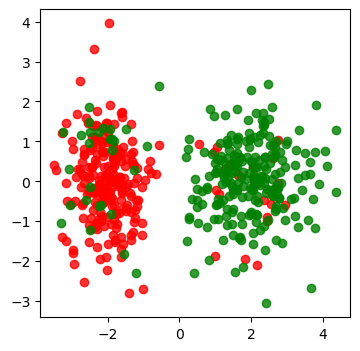

In [133]:
X, y = make_classification(
    n_samples=500, n_features=2, n_redundant=0, n_informative=1, random_state=1, flip_y=0.2,
    class_sep = 2, n_clusters_per_class=1) 

red = y == 0
green = y == 1
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(X[red, 0], X[red, 1], c="r", marker='o', alpha = 0.8)
ax.scatter(X[green, 0], X[green, 1], c="g", marker='o', alpha = 0.8)
plt.axis("tight")
plt.show()

## Circles

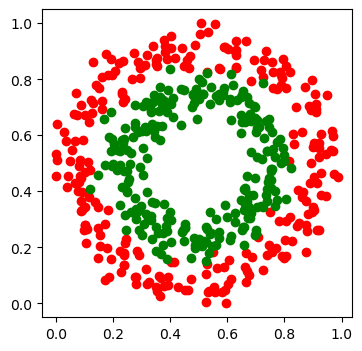

In [91]:
X, y = make_circles(n_samples=500, shuffle=True, noise=0.1, random_state=None, factor=0.6)
data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
data = pd.DataFrame(data)
X = (X - X.min())/(X.max() - X.min())
red = y == 0
green = y == 1
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
plt.axis("tight")
plt.show()

## Moon

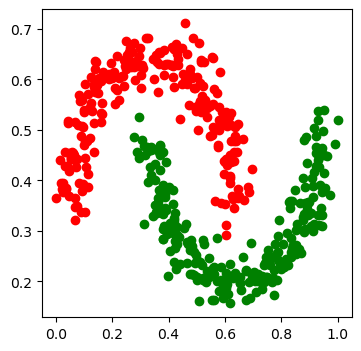

In [88]:
X, y = make_moons(n_samples=500, shuffle=True, noise=0.1, random_state=None)
X = (X - X.min())/(X.max() - X.min())
data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
data = pd.DataFrame(data)
red = y == 0
green = y == 1
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
plt.axis("tight")
plt.show()

## Ellipse

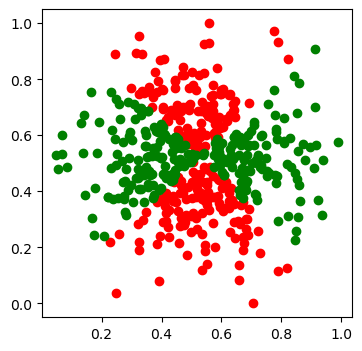

In [145]:
def gen_ellipse(n_samples, random_state=0):
    np.random.seed(random_state)
    x1 = np.random.normal(0, 1, n_samples)
    x2 = np.random.normal(0, 1, n_samples)
    y = x1**2 - x2**2
    X = np.array([x1, x2]).T
    y = np.where(y > 0, 1, 0)

    return X, y

X, y = gen_ellipse(500)
X = (X - X.min())/(X.max() - X.min())
red = y == 0
green = y == 1
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
plt.axis("tight")
plt.show()

## Regression